# DATA PREPROCESSING AN USER PROFILING

In [44]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.cluster import KMeans
from river import drift

In [45]:
# Load the datasets
users_df = pd.read_csv('users.csv')
utterances_df = pd.read_csv('utterances.csv')
errors_df = pd.read_csv('errors.csv')
exercises_df = pd.read_csv('exercises.csv')
user_progress_df = pd.read_csv('user_progress.csv')

# 1.1 Feature Engineering

# Combine relevant features
def combine_features(users_df, utterances_df, errors_df, exercises_df, user_progress_df):
    # Merge dataframes based on user_id
    combined_df = users_df.merge(utterances_df.groupby('user_id').agg({
        'grammar_overall_score': 'mean',
        'vocabulary_overall_score': 'mean',
        'pronunciation_overall_score': 'mean',
        'fluency_overall_score': 'mean'
    }), on='user_id', how='left')
    
    # Add error frequencies
    error_freq = errors_df.groupby(['user_id', 'category']).size().unstack(fill_value=0)
    error_freq.columns = [f'error_freq_{col}' for col in error_freq.columns]
    combined_df = combined_df.merge(error_freq, on='user_id', how='left')
    
    # Add exercise performance
    exercise_perf = exercises_df.groupby('user_id')['performance_score'].mean().reset_index()
    combined_df = combined_df.merge(exercise_perf, on='user_id', how='left')
    
    # Add user progress features
    combined_df = combined_df.merge(user_progress_df, on='user_id', how='left')
    
    return combined_df

combined_df = combine_features(users_df, utterances_df, errors_df, exercises_df, user_progress_df)

# Create aggregate features
def create_aggregate_features(combined_df, utterances_df, exercises_df):
    # Error frequency per category and subcategory
    error_freq = errors_df.groupby(['user_id', 'category', 'subcategory']).size().unstack(fill_value=0)
    error_freq.columns = [f'error_freq_{col[0]}_{col[1]}' for col in error_freq.columns]
    combined_df = combined_df.merge(error_freq, on='user_id', how='left')
    
    # Moving averages of performance scores
    performance_ma = exercises_df.groupby('user_id')['performance_score'].rolling(window=5).mean().reset_index()
    performance_ma = performance_ma.groupby('user_id')['performance_score'].last().reset_index()
    performance_ma.columns = ['user_id', 'performance_score_ma']
    combined_df = combined_df.merge(performance_ma, on='user_id', how='left')
    
    # User engagement metrics
    engagement_metrics = utterances_df.groupby('user_id').agg({
        'timestamp': lambda x: (pd.to_datetime(x.max()) - pd.to_datetime(x.min())).days,
        'utterance_id': 'count'
    }).reset_index()
    engagement_metrics.columns = ['user_id', 'days_active', 'total_utterances']
    engagement_metrics['sessions_per_week'] = engagement_metrics['total_utterances'] / (engagement_metrics['days_active'] / 7)
    combined_df = combined_df.merge(engagement_metrics, on='user_id', how='left')
    
    return combined_df

combined_df = create_aggregate_features(combined_df, utterances_df, exercises_df)
combined_df

combined_df.to_csv('combined_features.csv', index=False)

In [46]:
# 1.2 Normalization and Scaling

# Identify numerical and categorical columns
numerical_columns = combined_df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = combined_df.select_dtypes(include=['object']).columns

# Apply min-max scaling to numerical features
scaler = MinMaxScaler()
combined_df[numerical_columns] = scaler.fit_transform(combined_df[numerical_columns])

# One-hot encode categorical variables
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_categorical = encoder.fit_transform(combined_df[categorical_columns])
encoded_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_columns))

# Combine scaled numerical and encoded categorical features
preprocessed_df = pd.concat([combined_df[numerical_columns], encoded_df], axis=1)

preprocessed_df


,overall_progress,total_practice_time,exercises_completed,daily_active_days,weekly_active_days,total_sessions,avg_session_duration,adaptive_difficulty,engagement_score_x,grammar_overall_score,...,"recent_grammar_errors_['preposition_usage', 'subject_verb_agreement']",recent_grammar_errors_['preposition_usage'],"recent_grammar_errors_['subject_verb_agreement', 'article_usage']","recent_grammar_errors_['subject_verb_agreement', 'preposition_usage']","recent_grammar_errors_['subject_verb_agreement', 'tense_usage']",recent_grammar_errors_['subject_verb_agreement'],"recent_grammar_errors_['tense_usage', 'article_usage']","recent_grammar_errors_['tense_usage', 'preposition_usage']",recent_grammar_errors_['tense_usage'],recent_grammar_errors_[]
0,0.858349,0.045302,0.601340,0.500000,0.857143,0.839080,0.28,0.842103,0.711067,0.337504,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.858349,0.045302,0.601340,0.500000,0.857143,0.839080,0.28,0.842103,0.711067,0.337504,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.858349,0.045302,0.601340,0.500000,0.857143,0.839080,0.28,0.842103,0.711067,0.337504,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.858349,0.045302,0.601340,0.500000,0.857143,0.839080,0.28,0.842103,0.711067,0.337504,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.823235,0.620470,0.631491,0.266667,0.714286,0.701149,0.44,0.144421,0.633293,0.507980,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.565653,0.850000,0.904523,0.300000,0.142857,0.919540,0.44,0.221068,0.721157,0.299239,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
396,0.683231,0.105705,0.351759,0.233333,0.857143,0.160920,0.92,0.543523,0.880422,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
397,0.683231,0.105705,0.351759,0.233333,0.857143,0.160920,0.92,0.543523,0.880422,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
398,0.683231,0.105705,0.351759,0.233333,0.857143,0.160920,0.92,0.543523,0.880422,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


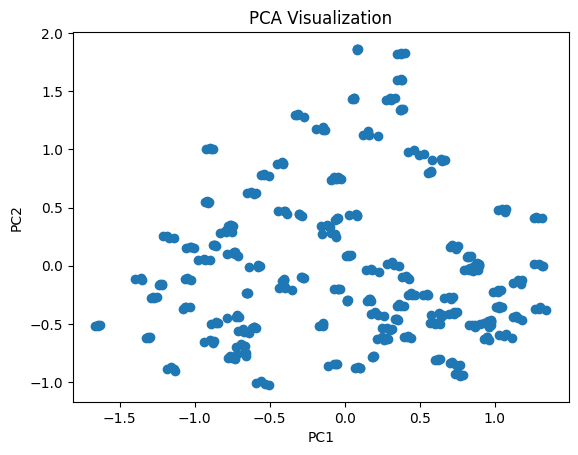

In [47]:
# 1.3 Dimensionality Reduction

# Apply PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(preprocessed_df)
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

#plot PCA
import matplotlib.pyplot as plt
plt.scatter(pca_df['PC1'], pca_df['PC2'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Visualization')
plt.show()



In [48]:

def create_time_based_features(combined_df, utterances_df, exercises_df):
    # Days since last practice
    last_practice = exercises_df.groupby('user_id')['timestamp'].max().reset_index()
    last_practice['days_since_last_practice'] = (pd.to_datetime('now') - pd.to_datetime(last_practice['timestamp'])).dt.days
    combined_df = combined_df.merge(last_practice[['user_id', 'days_since_last_practice']], on='user_id', how='left')
    
    # Weekly improvement rate
    exercises_df['timestamp'] = pd.to_datetime(exercises_df['timestamp'])  # Ensure timestamp is datetime
    weekly_scores = exercises_df.set_index('timestamp').groupby('user_id').resample('W')['performance_score'].mean().reset_index()
    weekly_scores['improvement_rate'] = weekly_scores.groupby('user_id')['performance_score'].pct_change()
    weekly_improvement = weekly_scores.groupby('user_id')['improvement_rate'].mean().reset_index()
    combined_df = combined_df.merge(weekly_improvement, on='user_id', how='left')
    
    return combined_df

combined_df = create_time_based_features(combined_df, utterances_df, exercises_df)

combined_df.columns

C:\Users\HP\AppData\Local\Temp\ipykernel_21940\3254878504.py:10: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  weekly_scores['improvement_rate'] = weekly_scores.groupby('user_id')['performance_score'].pct_change()


Index(['user_id', 'country', 'age_band', 'proficiency_level', 'interests',
       'cefr_level', 'overall_progress', 'total_practice_time',
       'exercises_completed', 'daily_active_days', 'weekly_active_days',
       'total_sessions', 'avg_session_duration', 'current_focus',
       'adaptive_difficulty', 'personalized_goals', 'engagement_score_x',
       'grammar_overall_score', 'vocabulary_overall_score',
       'pronunciation_overall_score', 'fluency_overall_score',
       'error_freq_fluency', 'error_freq_grammar', 'error_freq_pronunciation',
       'error_freq_vocabulary', 'performance_score', 'timestamp',
       'recent_grammar_errors', 'vocab_improvement', 'fluency_trend',
       'engagement_score_y', 'error_freq_a_c', 'error_freq_a_r',
       'error_freq_c_o', 'error_freq_c_o', 'error_freq_c_o', 'error_freq_f_i',
       'error_freq_i_d', 'error_freq_i_n', 'error_freq_p_a', 'error_freq_p_r',
       'error_freq_s_p', 'error_freq_s_u', 'error_freq_t_e', 'error_freq_v_o',
       '

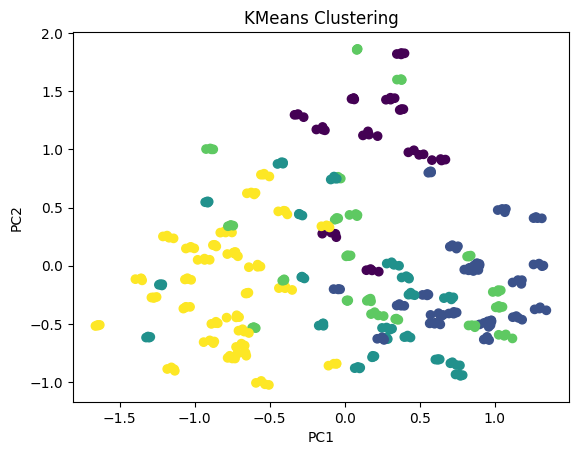

In [49]:
# 2. User Profiling and Clustering

# 2.1 Clustering Algorithm-CAN HAVE BETTER ALGORITHM HERE DEPENDING ON REAL DATA
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(preprocessed_df)
combined_df['cluster'] = cluster_labels

combined_df['cluster']

#Plotting the clusters
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=combined_df['cluster'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('KMeans Clustering')
plt.show()



In [50]:

# # Feature selection
# selector = SelectKBest(score_func=f_regression, k=20)
# selected_features = selector.fit_transform(preprocessed_df, combined_df['overall_progress'])
# selected_feature_names = preprocessed_df.columns[selector.get_support()].tolist()

In [51]:
# # 2.2 Dynamic User Profiling

# class DynamicUserProfile:
#     def __init__(self, user_id):
#         self.user_id = user_id
#         self.profile = {}
#         self.drift_detectors = {}
        
#     def update(self, new_data):
#         for feature, value in new_data.items():
#             if feature not in self.profile:
#                 self.profile[feature] = value
#                 self.drift_detectors[feature] = drift.ADWIN()
#             else:
#                 self.profile[feature] = 0.9 * self.profile[feature] + 0.1 * value
#                 drift_detected = self.drift_detectors[feature].update(value)
#                 if drift_detected:
#                     print(f"Concept drift detected for user {self.user_id} in feature {feature}")
                    
#     def get_profile(self):
#         return self.profile

# # Example usage of DynamicUserProfile
# user_profiles = {user_id: DynamicUserProfile(user_id) for user_id in combined_df['user_id']}

# # Simulate updating user profiles with new data
# for _, row in combined_df.iterrows():
#     user_id = row['user_id']
#     new_data = row[selected_feature_names].to_dict()
#     user_profiles[user_id].update(new_data)

# # Print sample user profile
# sample_user_id = combined_df['user_id'].iloc[0]
# print(f"Sample user profile for user {sample_user_id}:")
# print(user_profiles[sample_user_id].get_profile())

# Deep Knowledge Tracing Model Implementation-(ATTEMPT #2)

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [53]:

class LanguageLearningDataset(Dataset):
    def __init__(self, user_ids, exercise_sequences, performance_sequences):
        self.user_ids = user_ids
        self.exercise_sequences = exercise_sequences
        self.performance_sequences = performance_sequences
    
    def __len__(self):
        return len(self.user_ids)
    
    def __getitem__(self, idx):
        return (
            self.user_ids[idx],
            torch.LongTensor(self.exercise_sequences[idx]),
            torch.FloatTensor(self.performance_sequences[idx])
        )

def prepare_sequences(exercises_df, max_seq_len=50):
    exercises_df = exercises_df.sort_values(['user_id', 'timestamp'])
    
    # Map exercises to integer IDs
    exercise_map = {ex: i for i, ex in enumerate(exercises_df['subcategory'].unique())}
    exercises_df['exercise_id'] = exercises_df['subcategory'].map(exercise_map)
    
    user_sequences = exercises_df.groupby('user_id').agg({
        'exercise_id': list,
        'performance_score': list
    })
    
    # Pad or truncate sequences
    user_sequences['exercise_id'] = user_sequences['exercise_id'].apply(
        lambda x: x[:max_seq_len] if len(x) > max_seq_len else x + [0] * (max_seq_len - len(x))
    )
    user_sequences['performance_score'] = user_sequences['performance_score'].apply(
        lambda x: x[:max_seq_len] if len(x) > max_seq_len else x + [0] * (max_seq_len - len(x))
    )
    
    return (
        user_sequences.index.tolist(),
        user_sequences['exercise_id'].tolist(),
        user_sequences['performance_score'].tolist(),
        exercise_map
    ) 


In [54]:

user_ids, exercise_sequences, performance_sequences ,exercise_map = prepare_sequences(exercises_df)


train_users, test_users, train_exercises, test_exercises, train_performances, test_performances = train_test_split(
    user_ids, exercise_sequences, performance_sequences, test_size=0.2, random_state=42
)


train_dataset = LanguageLearningDataset(train_users, train_exercises, train_performances)
test_dataset = LanguageLearningDataset(test_users, test_exercises, test_performances)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [55]:


class DKTModel(nn.Module):
    def __init__(self, num_exercises, hidden_size, num_layers, num_categories):
        super(DKTModel, self).__init__()
        self.num_exercises = num_exercises
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_categories = num_categories
        
        self.exercise_embedding = nn.Embedding(num_exercises, hidden_size)
        self.lstm = nn.LSTM(hidden_size + 1, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_categories)
        
    def forward(self, exercise_sequences, performance_sequences):
        # Embed exercises
        embedded_exercises = self.exercise_embedding(exercise_sequences)
        
       
        lstm_input = torch.cat([embedded_exercises, performance_sequences.unsqueeze(-1)], dim=-1)
        
        # Pass through LSTM
        lstm_output, _ = self.lstm(lstm_input)
        
        # Pass through fully connected layer
        output = self.fc(lstm_output)
        
        return torch.sigmoid(output)


In [56]:
# Initialize the model
num_exercises = len(exercise_map)
hidden_size = 256
num_layers = 3
num_categories = 4  # Grammar, Vocabulary, Pronunciation, Fluency

model = DKTModel(num_exercises, hidden_size, num_layers, num_categories)


In [57]:
# 3. Train the model

criterion = nn.MSELoss()  # nn.BCE() , nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

num_epochs = 50

def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for user_ids, exercise_sequences, performance_sequences in train_loader:
            optimizer.zero_grad()

            # # Print the shapes of the input data
            # print(f"exercise_sequences shape: {exercise_sequences.shape}")
            # print(f"performance_sequences shape: {performance_sequences.shape}")
            
            # Forward pass
            outputs = model(exercise_sequences, performance_sequences)
            
            # Compute loss
            loss = criterion(outputs[:, :-1, :], performance_sequences[:, 1:].unsqueeze(-1).repeat(1, 1, num_categories))
            
            # Backward pass and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")

train_model(model, train_loader, criterion, optimizer, num_epochs)

Epoch 1/50, Loss: 0.1738
Epoch 2/50, Loss: 0.0789
Epoch 3/50, Loss: 0.0578
Epoch 4/50, Loss: 0.0414
Epoch 5/50, Loss: 0.0367
Epoch 6/50, Loss: 0.0346
Epoch 7/50, Loss: 0.0318
Epoch 8/50, Loss: 0.0288
Epoch 9/50, Loss: 0.0278
Epoch 10/50, Loss: 0.0260
Epoch 11/50, Loss: 0.0251
Epoch 12/50, Loss: 0.0241
Epoch 13/50, Loss: 0.0234
Epoch 14/50, Loss: 0.0229
Epoch 15/50, Loss: 0.0223
Epoch 16/50, Loss: 0.0223
Epoch 17/50, Loss: 0.0222
Epoch 18/50, Loss: 0.0212
Epoch 19/50, Loss: 0.0207
Epoch 20/50, Loss: 0.0203
Epoch 21/50, Loss: 0.0201
Epoch 22/50, Loss: 0.0194
Epoch 23/50, Loss: 0.0183
Epoch 24/50, Loss: 0.0172
Epoch 25/50, Loss: 0.0182
Epoch 26/50, Loss: 0.0170
Epoch 27/50, Loss: 0.0164
Epoch 28/50, Loss: 0.0158
Epoch 29/50, Loss: 0.0145
Epoch 30/50, Loss: 0.0136
Epoch 31/50, Loss: 0.0124
Epoch 32/50, Loss: 0.0121
Epoch 33/50, Loss: 0.0108
Epoch 34/50, Loss: 0.0102
Epoch 35/50, Loss: 0.0094
Epoch 36/50, Loss: 0.0089
Epoch 37/50, Loss: 0.0085
Epoch 38/50, Loss: 0.0079
Epoch 39/50, Loss: 0.

In [58]:
# 4. Evaluate the model

def evaluate_model(model, test_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for user_ids, exercise_sequences, performance_sequences in test_loader:
            outputs = model(exercise_sequences, performance_sequences)
            loss = criterion(outputs[:, :-1, :], performance_sequences[:, 1:].unsqueeze(-1).repeat(1, 1, num_categories))
            total_loss += loss.item()
    
    return total_loss / len(test_loader)

test_loss = evaluate_model(model, test_loader)
print(f"Test Loss: {test_loss:.4f}")

# 5. Use the model for knowledge tracing

def trace_knowledge(model, user_id, exercise_sequence, performance_sequence):
    model.eval()
    with torch.no_grad():
        exercise_tensor = torch.LongTensor(exercise_sequence).unsqueeze(0)
        performance_tensor = torch.FloatTensor(performance_sequence).unsqueeze(0)
        
        outputs = model(exercise_tensor, performance_tensor)
        
        # Return the knowledge state after the last exercise
        return outputs[0, -1, :].numpy()

# Example usage
sample_user_id = test_users[2]
sample_exercise_sequence = test_exercises[0]
sample_performance_sequence = test_performances[0]

knowledge_state = trace_knowledge(model, sample_user_id, sample_exercise_sequence, sample_performance_sequence)
print(f"Estimated knowledge state for user {sample_user_id}:")
print(f"Grammar: {knowledge_state[0]:.4f}")
print(f"Vocabulary: {knowledge_state[1]:.4f}")
print(f"Pronunciation: {knowledge_state[2]:.4f}")
print(f"Fluency: {knowledge_state[3]:.4f}")


knowledge_state

Test Loss: 0.0381
Estimated knowledge state for user af45a83c-5582-4552-8645-e80d247d8691:
Grammar: 0.0011
Vocabulary: 0.0012
Pronunciation: 0.0011
Fluency: 0.0012


array([0.00112935, 0.00116063, 0.00114039, 0.00123105], dtype=float32)